In [1]:
from get_data import fetch_data
import tiktoken
import matplotlib.pyplot as plt
import datasets
import numpy as np
from urllib.parse import urlparse
from collections import Counter
import math
tokenizer = tiktoken.get_encoding('gpt2')



/home/ubuntu/miniconda3/envs/HW3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data, val_data = fetch_data()
print(len(train_data))

/home/ubuntu/miniconda3/envs/HW3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/miniconda3/envs/HW3/lib/python3.10/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")
Extracting data files: 100%|██████████| 1/1 [00:10<00:00, 10.32s/it]
Generating train split: 296821 examples [00:03, 80313.48 examples/s]

281979


In [18]:
def get_word_count(dataset):
    total_words = sum([len(i['text'].split(' ')) for i in dataset])
    return total_words

In [19]:
total_words = get_word_count(train_data)

In [20]:
print(f"Total Words: {total_words}")

220972724


In [61]:
tokenizer = tiktoken.get_encoding('gpt2')
tokenised_text = tokenizer.encode(train_data[0]['text'])

list

In [70]:
def tokenise(sample):
    tokenised_text = tokenizer.encode(sample['text'])
    tokenised_text.append(tokenizer.eot_token)
    return {"tokenised_text": tokenised_text}    

In [71]:
train_data_tokenised = train_data.map(tokenise)

Map: 100%|██████████| 281979/281979 [06:33<00:00, 715.88 examples/s]


In [72]:
print(train_data_tokenised)

Dataset({
    features: ['text', 'timestamp', 'url', 'tokenised_text'],
    num_rows: 281979
})


In [77]:
def get_token_counts(dataset):
    total_tokens = sum([len(i['tokenised_text']) for i in dataset])
    return total_tokens

In [79]:
total_tokens = get_token_counts(train_data_tokenised)

In [80]:
print(total_tokens)

499243490


In [85]:
def plot_document_size_hist(dataset):
    token_counts = [len(i) for i in dataset['tokenised_text']]
    print(f"Minimum Token Count: {min(token_counts)}")
    print(f"Maximum token Count: {max(token_counts)}")
    plt.figure(figsize=(10, 6))
    plt.hist(token_counts, bins=20, color='skyblue', edgecolor='black')
    plt.title('Histogram of Document Sizes (Number of Tokens)')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Number of Documents')
    plt.grid(axis='y', alpha=0.75)

    # Showing the histogram
    plt.show()

Minimum Token Count: 2
Maximum token Count: 212721


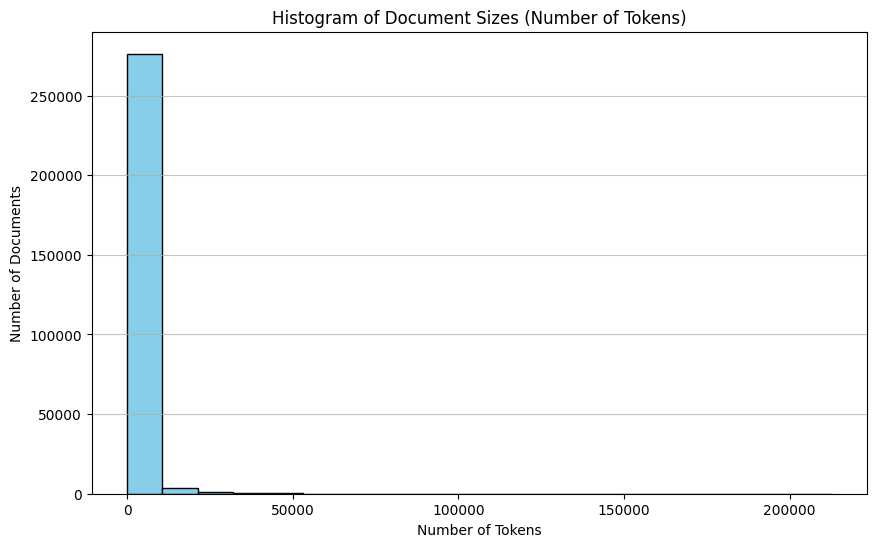

In [87]:
plot_document_size_hist(train_data_tokenised)

In [243]:
def plot_domain_hist(domains, token_counts, xlabel):

    log_token_counts = np.log10(token_counts)

    plt.figure(figsize=(10, 8))
    plt.barh(domains, log_token_counts, color='skyblue')
    plt.xlabel(f'# {xlabel} (log scale, base 10)')
    plt.ylabel('Domain')
    plt.title('Histogram of Document Sizes')
    plt.gca().invert_yaxis()  # Inverts the Y-axis so the largest bar is at the top
    plt.show()

In [153]:
def get_domain(url):
    import tldextract
    extracted = tldextract.extract(url)
    tld = extracted.suffix
    return tld

In [209]:
def get_website(url):
    parsed_url = urlparse(url)
    website = parsed_url.netloc
    return website

In [217]:
def get_key_values(c, top_n):
    keys = [item[0] for item in c.most_common(top_n)]
    values = [item[1] for item in c.most_common(top_n)]
    return keys, values

In [210]:
from collections import Counter
def domain_token_counts(dataset, tld = True):
    domain_counter = Counter()
    for i in dataset:
        if tld:
            count_key = get_domain(i['url'])
        else:
            count_key = get_website(i['url'])
        domain_counter[count_key] = domain_counter[count_key] + len(i['tokenised_text'])
    return domain_counter

In [179]:
domain_counts = domain_token_counts(train_data_tokenised, tld=True)
top_level_domains, tld_counts = get_key_values(domain_counts, 25)

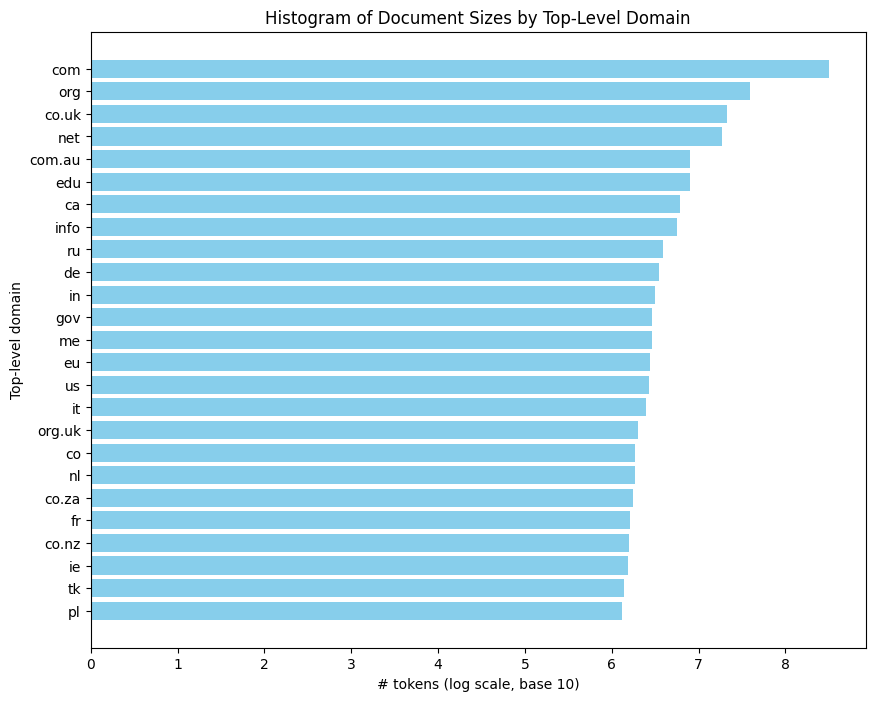

In [196]:
plot_domain_hist(domains=top_level_domains, token_counts=tld_counts)

In [213]:
url_counts = domain_token_counts(train_data_tokenised, tld = False)

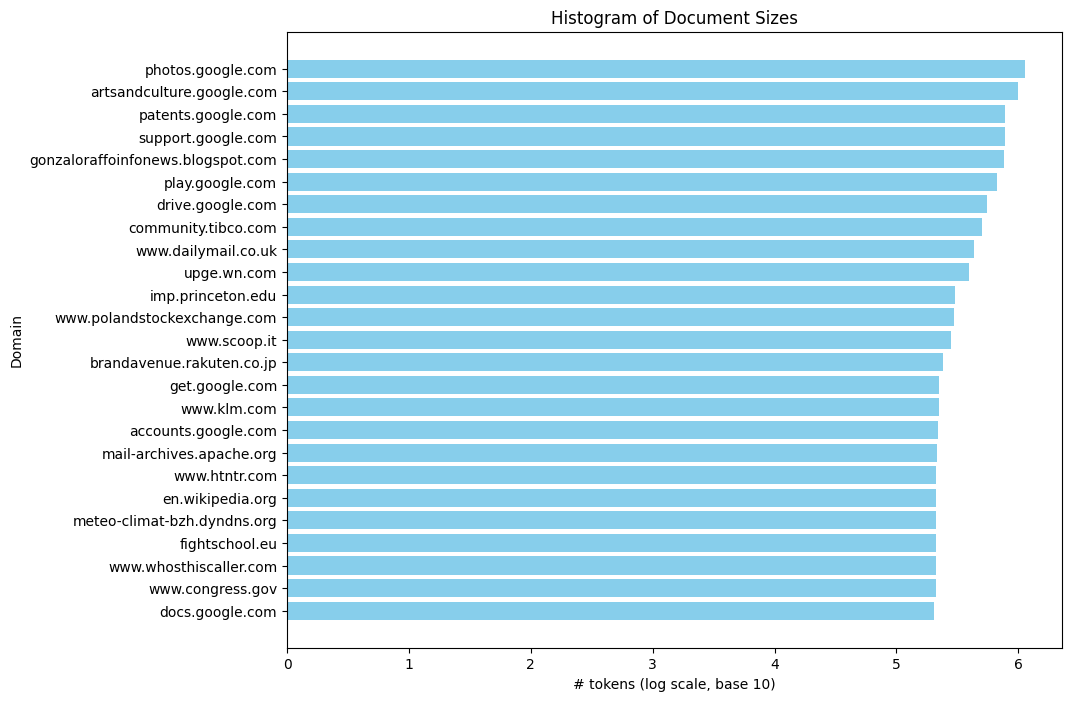

In [220]:
urls, url_token_counts = get_key_values(url_counts, 25)
plot_domain_hist(domains=urls, token_counts=url_token_counts)

In [ ]:
def domain_document_counts(dataset, tld = True):
    domain_counter = Counter()
    for i in dataset:
        if tld:
            count_key = get_domain(i['url'])
        else:
            count_key = get_website(i['url'])
        domain_counter[count_key] = domain_counter[count_key] + 1
    return domain_counter

In [238]:
domain_doc_counts = Counter(list(map(get_domain, train_data_tokenised['url'])))
url_doc_counts = Counter(list(map(get_website, train_data_tokenised['url'])))

In [240]:
top_level_domains, tld_doc_counts = get_key_values(domain_doc_counts, 25)
urls, u_doc_count = get_key_values(url_doc_counts, 25)

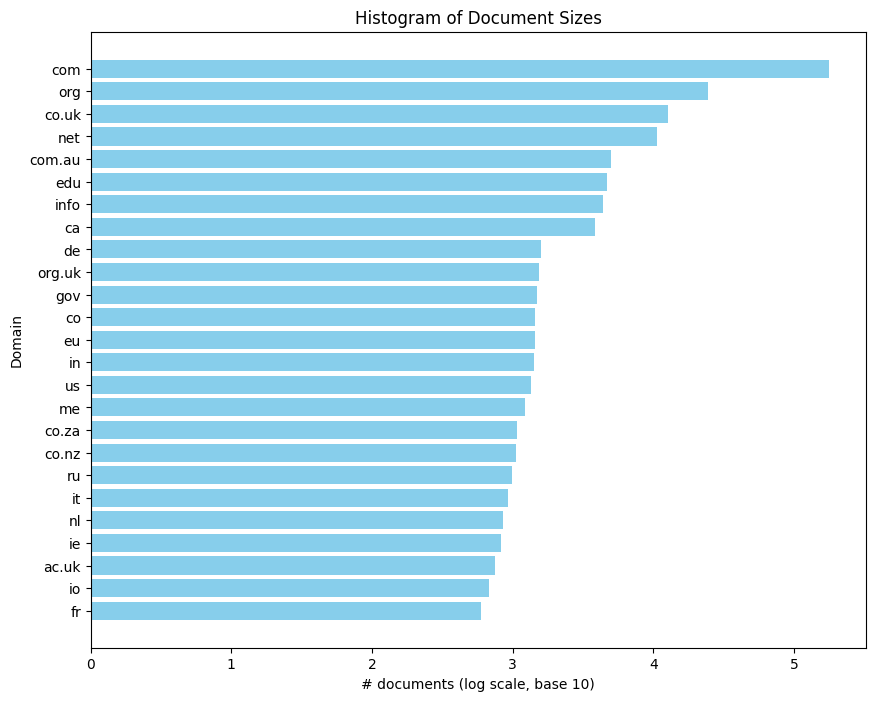

In [244]:
plot_domain_hist(domains=top_level_domains, token_counts=tld_doc_counts, xlabel="documents")


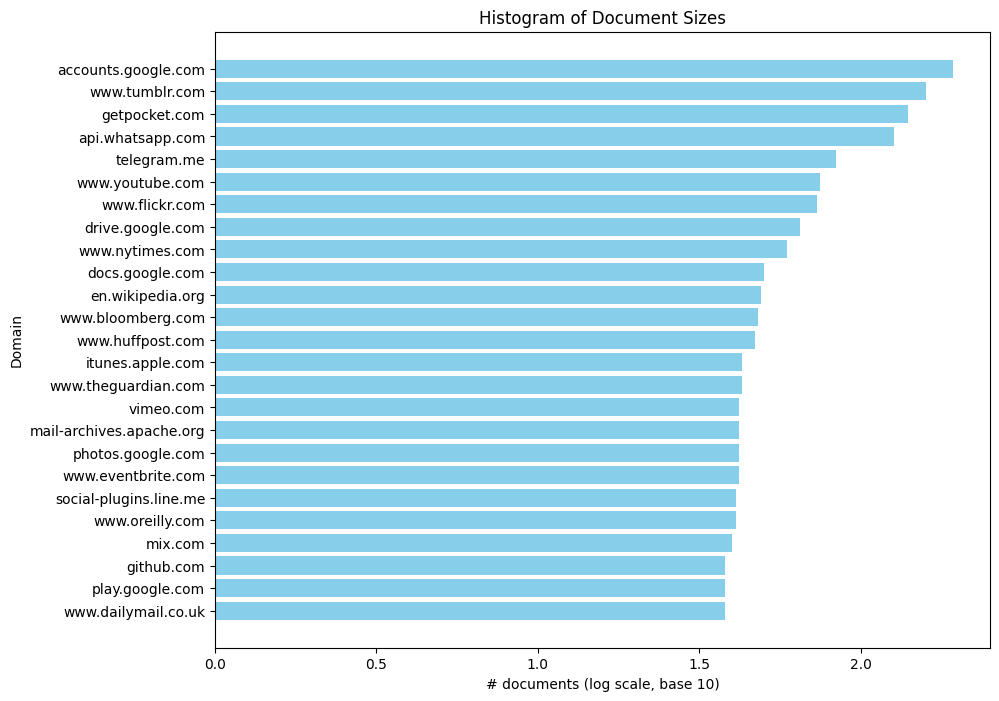

In [245]:
plot_domain_hist(domains=urls, token_counts=u_doc_count, xlabel='documents')

In [2]:
train_data_tokenised = datasets.load_from_disk('train_data_tokenised')

In [32]:
def plot_digit_hist(token_counts, n):
    plt.hist(token_counts, bins=range(min(token_counts), max(token_counts) + 2), align='left', rwidth=0.8)
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Number of Tokens in Every {n}-Digit Number')
    plt.xticks(range(min(token_counts), max(token_counts) + 1))
    plt.show()

In [33]:
def get_n_digit_nums(n):
    numbers = [str(i) for i in range(int(math.pow(10, n - 1)), int(math.pow(10, n)))]
    print(numbers[0], numbers[-1])
    token_counts = [len(i) for i in tokenizer.encode_batch(numbers)]
    return token_counts

100 999


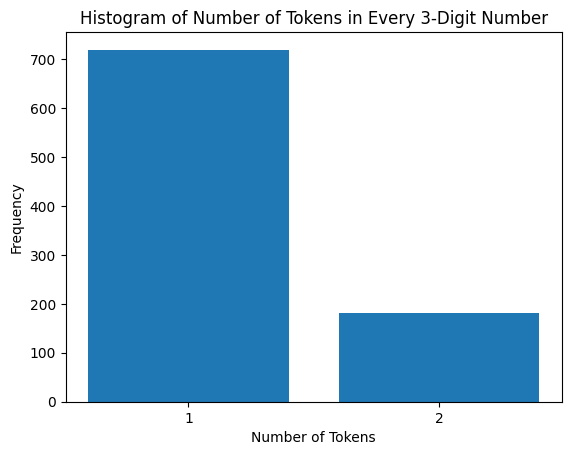

In [34]:
plot_digit_hist(get_n_digit_nums(3), 3)

10000 99999


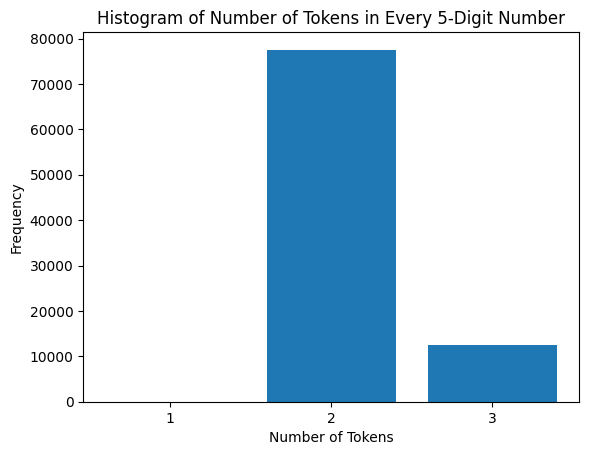

In [35]:
plot_digit_hist(get_n_digit_nums(5), 5)

In [4]:
def get_suffixes(s):
    suffixes = [s[i:] for i in range(len(s))]
    return suffixes

In [10]:
s = "Delicious cat food for $1#My cat is cute#cat food for $1#"
suf = get_suffixes(s)
print(len(suf))
sorted_suf = sorted(suf)

57


In [9]:
sorted(suf)

[' $1#',
 ' $1#My cat is cute#cat food for $1#',
 ' cat food for $1#My cat is cute#cat food for $1#',
 ' cat is cute#cat food for $1#',
 ' cute#cat food for $1#',
 ' food for $1#',
 ' food for $1#My cat is cute#cat food for $1#',
 ' for $1#',
 ' for $1#My cat is cute#cat food for $1#',
 ' is cute#cat food for $1#',
 '#',
 '#My cat is cute#cat food for $1#',
 '#cat food for $1#',
 '$1#',
 '$1#My cat is cute#cat food for $1#',
 '1#',
 '1#My cat is cute#cat food for $1#',
 'Delicious cat food for $1#My cat is cute#cat food for $1#',
 'My cat is cute#cat food for $1#',
 'at food for $1#',
 'at food for $1#My cat is cute#cat food for $1#',
 'at is cute#cat food for $1#',
 'cat food for $1#',
 'cat food for $1#My cat is cute#cat food for $1#',
 'cat is cute#cat food for $1#',
 'cious cat food for $1#My cat is cute#cat food for $1#',
 'cute#cat food for $1#',
 'd for $1#',
 'd for $1#My cat is cute#cat food for $1#',
 'e#cat food for $1#',
 'elicious cat food for $1#My cat is cute#cat food fo

In [33]:
def combine_documents(documents):
    combined = ""
    doc_indices = []
    delimiter = "#"
    for i, doc in enumerate(documents):
        combined += doc + delimiter
        doc_indices.extend([i] * (len(doc) + len(delimiter)))
    return combined, doc_indices

def build_suffix_array(s):
    return [(s[i:], i) for i in range(len(s) - 9)]

def find_duplicates_with_hashmap(documents):
    combined, doc_indices = combine_documents(documents)
    suffix_array = build_suffix_array(combined)
    suffix_array.sort()

    hashmap = {}
    duplicates = set()
    for _, idx in suffix_array:
        # Check if the 10-character sequence is within a single document
        if idx + 9 < len(combined) and doc_indices[idx] == doc_indices[idx + 9]:
            seq = combined[idx:idx + 10]
            if seq in hashmap and hashmap[seq] != doc_indices[idx]:
                duplicates.update({doc_indices[idx], hashmap[seq]})
                print(duplicates)
            hashmap[seq] = doc_indices[idx]

    print(hashmap)

    return duplicates

# Finding duplicate documents using hashmaps



# Given documents
documents = [
    "Delicious cat food for $1",
    "My cat is cute",
    "cat food for $1", 
    "all cat food for $1"
]

# Finding duplicate documents
duplicate_docs = find_duplicates_with_hashmap(documents)
duplicate_docs


{0, 3}
{0, 3}
{0, 2, 3}
{0, 2, 3}
{0, 2, 3}
{0, 2, 3}
{0, 2, 3}
{0, 2, 3}
{0, 2, 3}
{0, 2, 3}
{0, 2, 3}
{0, 2, 3}
{0, 2, 3}
{0, 2, 3}
{0, 2, 3}
{' cat food ': 0, ' cat is cu': 1, ' food for ': 2, 'Delicious ': 0, 'My cat is ': 1, 'all cat fo': 3, 'at food fo': 2, 'at is cute': 1, 'cat food f': 2, 'cat is cut': 1, 'cious cat ': 0, 'elicious c': 0, 'food for $': 2, 'icious cat': 0, 'ious cat f': 0, 'l cat food': 3, 'licious ca': 0, 'll cat foo': 3, 'od for $1#': 2, 'ood for $1': 2, 'ous cat fo': 0, 's cat food': 0, 't food for': 2, 't is cute#': 1, 'us cat foo': 0, 'y cat is c': 1}


{0, 2, 3}

In [21]:
a = [1, 1, 1, 1, 1]
a[0:5] == 1

False

In [ ]:
import re

non_english_regex = re.compile(r'[^\u0000-\u007F]+')
non_english_regex.search(text)